In [1]:
import base64
import datetime
import json
import os
import random
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image

np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load the Data

In [2]:
tr = pd.read_json('input/train.json', convert_dates=['created'])
print len(tr)

49352


In [3]:
tr.dtypes

bathrooms                 float64
bedrooms                    int64
building_id                object
created            datetime64[ns]
description                object
display_address            object
features                   object
interest_level             object
latitude                  float64
listing_id                  int64
longitude                 float64
manager_id                 object
photos                     object
price                       int64
street_address             object
dtype: object

In [4]:
tr.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [5]:
te = pd.read_json('input/test.json', convert_dates=['created'])
te['interest_level'] = np.nan
print len(te)

74659


In [6]:
te.dtypes

bathrooms                 float64
bedrooms                    int64
building_id                object
created            datetime64[ns]
description                object
display_address            object
features                   object
latitude                  float64
listing_id                  int64
longitude                 float64
manager_id                 object
photos                     object
price                       int64
street_address             object
interest_level            float64
dtype: object

In [7]:
te.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street,NaN
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street,NaN
100,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,9ca6f3baa475c37a3b3521a394d65467,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street,NaN
1000,1.0,2,783d21d013a7e655bddc4ed0d461cc5e,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,South Third Street\r,"[Roof Deck, Balcony, Elevator, Laundry in Buil...",40.7109,7143442,-73.9571,0b9d5db96db8472d7aeb67c67338c4d2,[https://photos.renthop.com/2/7143442_0879e9e0...,3300,251 South Third Street\r,NaN
100000,2.0,2,6134e7c4dd1a98d9aee36623c9872b49,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...","Midtown West, 8th Ave","[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.7650,6860601,-73.9845,b5eda0eb31b042ce2124fd9e9fcfce2f,[https://photos.renthop.com/2/6860601_c96164d8...,4900,260 West 54th Street,NaN


In [8]:
ss = pd.read_csv('input/sample_submission.csv')
print len(ss)

74659


In [9]:
ss.head()

,listing_id,high,medium,low
0,7142618,0.077788,0.227529,0.694683
1,7210040,0.077788,0.227529,0.694683
2,7174566,0.077788,0.227529,0.694683
3,7191391,0.077788,0.227529,0.694683
4,7171695,0.077788,0.227529,0.694683


In [10]:
d = pd.concat([tr, te])
print len(d)

124011


In [11]:
d.created = d.created.astype('datetime64[ns]')

In [12]:
d.dtypes

bathrooms                 float64
bedrooms                    int64
building_id                object
created            datetime64[ns]
description                object
display_address            object
features                   object
interest_level             object
latitude                  float64
listing_id                  int64
longitude                 float64
manager_id                 object
photos                     object
price                       int64
street_address             object
dtype: object

In [13]:
d.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [14]:
def summary_categorical(col_name):
    print '-' * 30, '\n', 'dtype:           ', d[col_name].dtype
    print '-' * 30, '\n', 'np.na count:     ', d[col_name].isnull().sum()
    print '-' * 30, '\n', 'np.na ratio:     ', 1.0 * d[col_name].isnull().sum() / len(d)
    print '-' * 30, '\n', 'distinct values: ', len(d[col_name].value_counts())
    print '-' * 30, '\n', 'top 10 values:'
    print d[col_name].value_counts().head(10)
    print '-' * 30, '\n', 'bottom 10 values:'
    print d[col_name].value_counts().tail(10)
    print '-' * 30

In [15]:
def summary_numerical(col_name):
    print '-' * 30, '\n', 'dtype:           ', d[col_name].dtype
    print '-' * 30, '\n', 'np.na count:     ', d[col_name].isnull().sum()
    print '-' * 30, '\n', 'np.na ratio:     ', 1.0 * d[col_name].isnull().sum() / len(d)
    print '-' * 30, '\n', 'distinct values: ', len(d[col_name].value_counts())
    print '-' * 30, '\n', 'top 3 values:'
    print d[col_name].value_counts().head(3)
    print '-' * 30, '\n', 'bottom 3 values:'
    print d[col_name].value_counts().tail(3)
    print '-' * 30
    print d[col_name].describe()
    print '-' * 30

# Bathrooms

In [16]:
col_name = 'bathrooms'
summary_numerical(col_name)

------------------------------ 
dtype:            float64
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  18
------------------------------ 
top 3 values:
1.0    99086
2.0    19230
3.0     1861
Name: bathrooms, dtype: int64
------------------------------ 
bottom 3 values:
112.0    1
7.5      1
10.0     1
Name: bathrooms, dtype: int64
------------------------------
count    124011.000000
mean          1.212622
std           0.595209
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         112.000000
Name: bathrooms, dtype: float64
------------------------------


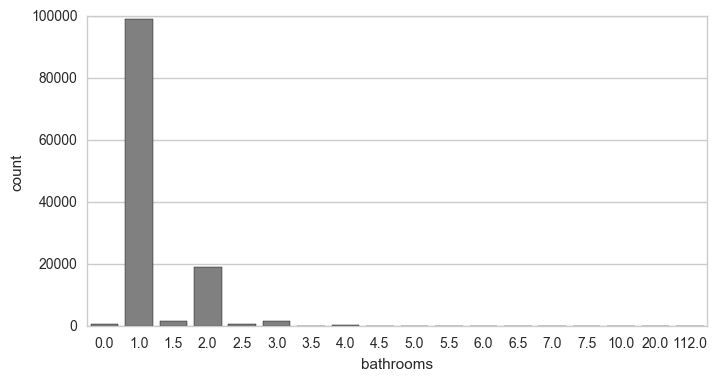

In [17]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=d[col_name], color='grey')

# Bedrooms

In [18]:
col_name = 'bedrooms'
summary_numerical(col_name)

------------------------------ 
dtype:            int64
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  9
------------------------------ 
top 3 values:
1    39608
2    37114
0    23564
Name: bedrooms, dtype: int64
------------------------------ 
bottom 3 values:
6    112
7      6
8      2
Name: bedrooms, dtype: int64
------------------------------
count    124011.000000
mean          1.543460
std           1.110203
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           8.000000
Name: bedrooms, dtype: float64
------------------------------


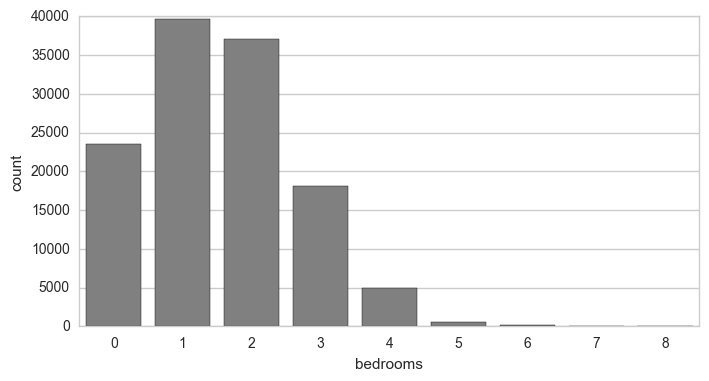

In [19]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=d[col_name], color='grey')

# Building ID

In [20]:
col_name = 'building_id'
summary_categorical(col_name)

------------------------------ 
dtype:            object
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  11635
------------------------------ 
top 10 values:
0                                   20664
96274288c84ddd7d5c5d8e425ee75027      705
11e1dec9d14b1a9e528386a2504b3afc      546
bb8658a3e432fb62a440615333376345      522
80a120d6bc3aba97f40fee8c2204524b      510
ce6d18bf3238e668b2bf23f4110b7b67      459
f68bf347f99df026f4faad43cc604048      457
c94301249b8c09429d329864d58e5b82      410
ea9045106c4e1fe52853b6af941f1c69      397
128d4af0683efc5e1eded8dc8044d5e3      385
Name: building_id, dtype: int64
------------------------------ 
bottom 10 values:
acd47968f692ac557e7ec0a5366d432a    1
4ad99d3ff2122320ec6ea3b3a7bdbfd5    1
64069059b73b807ac61035feee23be43    1
4289b09dbee1744651630f81b04feef9    1
5d3daefbfa3db944f0ab197734720815    1
81553f8061dadb0c7d7091daedb84bd7    1
f3f9

# Created

In [21]:
col_name = 'created'
summary_numerical(col_name)

------------------------------ 
dtype:            datetime64[ns]
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  119722
------------------------------ 
top 3 values:
2016-05-05 01:22:05    4
2016-06-11 03:22:50    4
2016-05-14 03:22:11    4
Name: created, dtype: int64
------------------------------ 
bottom 3 values:
2016-05-14 05:35:03    1
2016-06-26 20:33:54    1
2016-06-21 02:25:42    1
Name: created, dtype: int64
------------------------------
count                  124011
unique                 119722
top       2016-05-05 01:22:05
freq                        4
first     2016-04-01 22:12:41
last      2016-06-29 21:55:35
Name: created, dtype: object
------------------------------


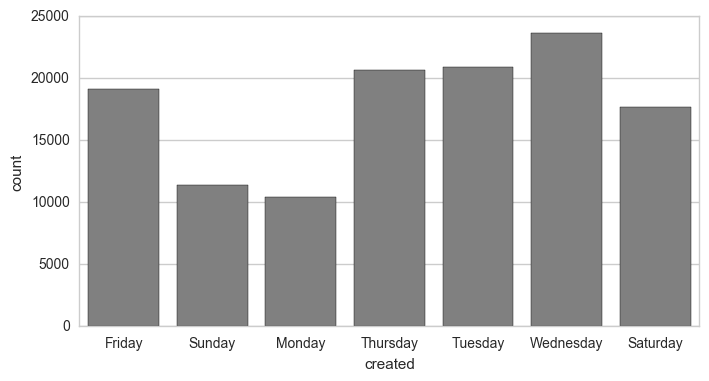

In [22]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(d[col_name].dt.weekday_name, color='grey')

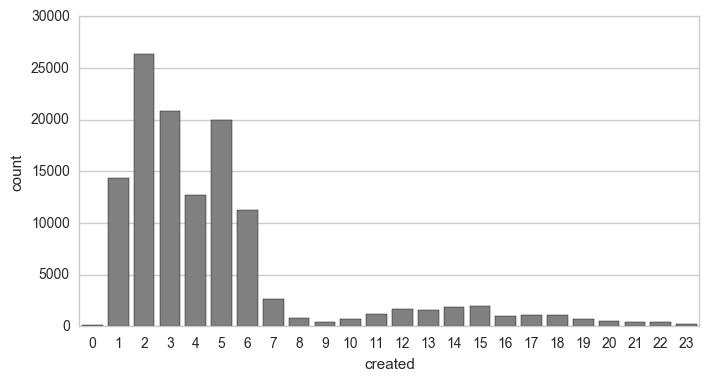

In [23]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(d[col_name].dt.hour, color='grey')

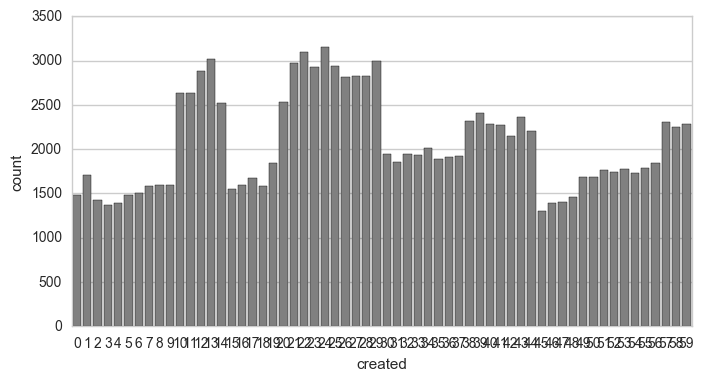

In [24]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(d[col_name].dt.minute, color='grey')

# Description

(0, 2500)

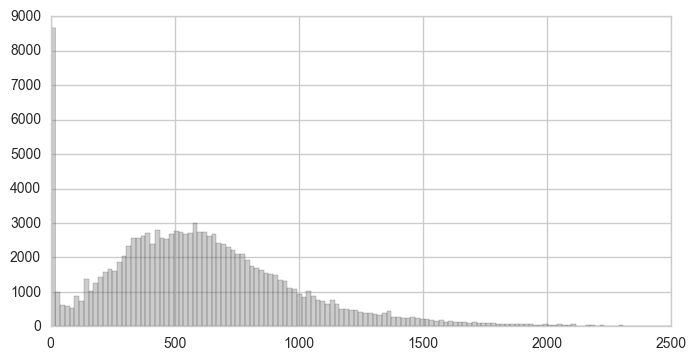

In [25]:
desc_len_chars = [len(desc) for desc in d.description.tolist()]
plt.figure(figsize=(8, 4))
ax = sns.distplot(a=desc_len_chars, color='grey', kde=False, bins=1000)
plt.xlim((0, 2500))

(0, 400)

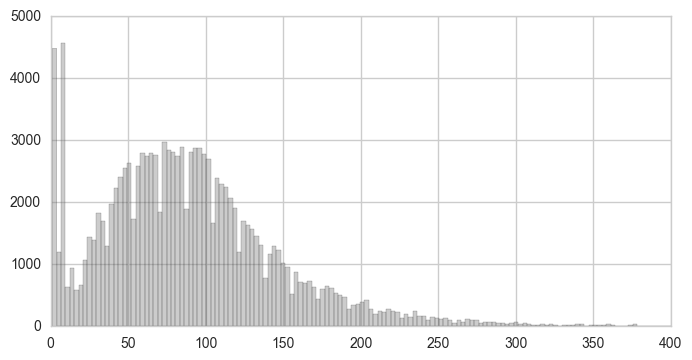

In [26]:
desc_len_words = [len(desc.split(' ')) for desc in d.description.tolist()]
plt.figure(figsize=(8, 4))
ax = sns.distplot(a=desc_len_words, color='grey', kde=False, bins=1000)
plt.xlim((0, 400))

# Display Address

In [27]:
col_name = 'display_address'
summary_categorical(col_name)

------------------------------ 
dtype:            object
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  16068
------------------------------ 
top 10 values:
Broadway             1163
East 34th Street      868
Wall Street           853
Second Avenue         838
West 37th Street      722
First Avenue          678
West Street           649
John Street           585
Gold Street           572
Washington Street     553
Name: display_address, dtype: int64
------------------------------ 
bottom 10 values:
585 East 21st St. #5H         1
145-20 223 street             1
220 Walworth                  1
East 66th *TRUE 2 BED*        1
37th and 3rd ave              1
CHELSEA!! HOW DELIGHTFUL!!    1
975 Sherman Avenue            1
610 East 9th Street           1
East 65th                     1
66th St. & 2nd                1
Name: display_address, dtype: int64
------------------------------


# Features

In [28]:
col_name = 'features'
summary_categorical(col_name)

------------------------------ 
dtype:            object
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  17378
------------------------------ 
top 10 values:
[]                                                 8135
[Pre-War, Dogs Allowed, Cats Allowed]              3568
[Cats Allowed, Dogs Allowed]                       2703
[Hardwood Floors]                                  2643
[Pre-War]                                          2354
[Dogs Allowed, Cats Allowed]                       1391
[Elevator]                                         1299
[Dishwasher, Hardwood Floors]                      1124
[Doorman, Elevator, Dogs Allowed, Cats Allowed]    1046
[No Fee]                                            787
Name: features, dtype: int64
------------------------------ 
bottom 10 values:
[Doorman, Elevator, Laundry in Unit, Dishwasher, Hardwood Floors, Outdoor Space, Dogs Allowed, 

# Coordinates

In [29]:
col_name = 'latitude'
summary_numerical(col_name)

------------------------------ 
dtype:            float64
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  2675
------------------------------ 
top 3 values:
40.7568    762
40.7530    750
40.7074    643
Name: latitude, dtype: int64
------------------------------ 
bottom 3 values:
40.5873    1
40.6558    1
42.0463    1
Name: latitude, dtype: int64
------------------------------
count    124011.000000
mean         40.737641
std           0.744337
min           0.000000
25%          40.728000
50%          40.751700
75%          40.774300
max          44.883500
Name: latitude, dtype: float64
------------------------------


In [30]:
col_name = 'longitude'
summary_numerical(col_name)

------------------------------ 
dtype:            float64
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  1959
------------------------------ 
top 3 values:
-73.9982    741
-73.9875    634
-73.9838    624
Name: longitude, dtype: int64
------------------------------ 
bottom 3 values:
-74.0490    1
-73.9106    1
-74.0871    1
Name: longitude, dtype: int64
------------------------------
count    124011.000000
mean        -73.949434
std           1.372882
min        -121.488000
25%         -73.991700
50%         -73.977800
75%         -73.954700
max           0.000000
Name: longitude, dtype: float64
------------------------------


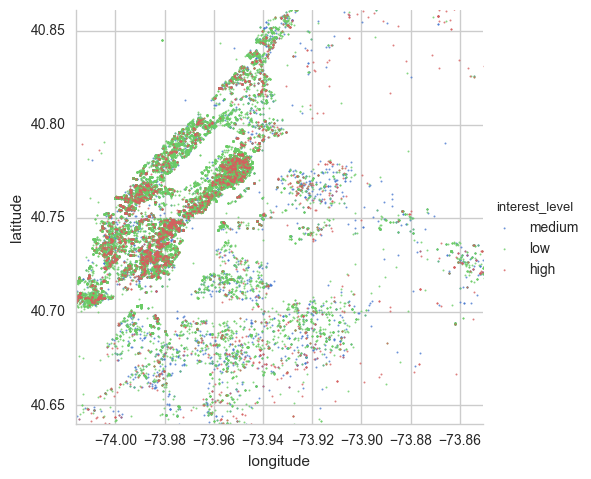

In [31]:
_ = plt.figure(figsize=(12,12))
_ = sns.lmplot(
    x='longitude',
    y='latitude',
    data=d,
    fit_reg=False,
    hue='interest_level',
    scatter_kws={
        "marker": ".", 
        "s": 2})
_ = plt.xlim((d.longitude.quantile(0.01), d.longitude.quantile(0.99)))
_ = plt.ylim((d.latitude.quantile(0.01), d.latitude.quantile(0.99)))

# Manager ID

In [32]:
col_name = 'manager_id'
summary_categorical(col_name)

------------------------------ 
dtype:            object
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  4399
------------------------------ 
top 10 values:
e6472c7237327dd3903b3d6f6a94515a    6387
6e5c10246156ae5bdcd9b487ca99d96a    1683
8f5a9c893f6d602f4953fcc0b8e6e9b4    1011
cb87dadbca78fad02b388dc9e8f25a5b     971
62b685cc0d876c3a1a51d63a0d6a8082     956
9df32cb8dda19d3222d66e69e258616b     862
2aa9bfa5f67ed9997ea341dee8a3a271     853
b7de4cb395920136663132057fa89d84     849
ad3d8ddc52c7e0859b5c6c7f7949c3bd     732
c9c33695ee2a2f818e9f1d8f7d1c4b39     731
Name: manager_id, dtype: int64
------------------------------ 
bottom 10 values:
947ae5d7d68d4e3dd500e60563065da7    1
799d6cf108cb6350e10eb2a4d77dc075    1
6e7b18d0e13c7d8ab2f25f19fc206f15    1
b3a3aae7392093169b83436f8491adc0    1
84a791745d2377d963f05ebf45bee94b    1
28f2ee59507afb3229af1cd81b9d1f08    1
0ead4ce211989abe

# Photos

In [33]:
# ...

# Price

In [34]:
col_name = 'price'
summary_numerical(col_name)

------------------------------ 
dtype:            int64
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  3964
------------------------------ 
top 3 values:
2500    2668
3200    2198
3000    2041
Name: price, dtype: int64
------------------------------ 
bottom 3 values:
4237    1
2482    1
5859    1
Name: price, dtype: int64
------------------------------
count    1.240110e+05
mean     3.781324e+03
std      1.582988e+04
min      1.000000e+00
25%      2.495000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64
------------------------------


(0, 15000)

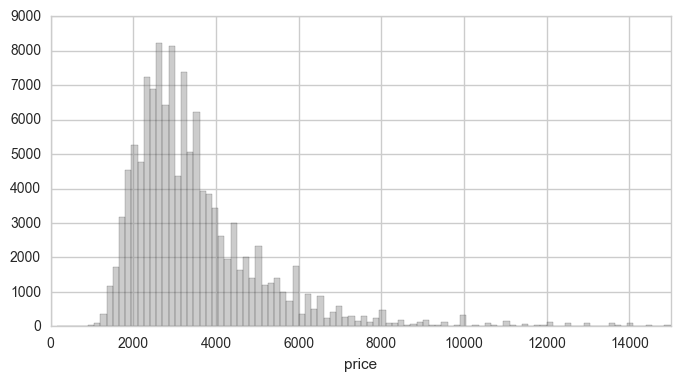

In [35]:
plt.figure(figsize=(8, 4))
ax = sns.distplot(a=d.loc[d[col_name] < 15000, col_name], color='grey', kde=False, bins=100)
plt.xlim((0, 15000))

# Street Address

In [36]:
col_name = 'street_address'
summary_categorical(col_name)

------------------------------ 
dtype:            object
------------------------------ 
np.na count:      0
------------------------------ 
np.na ratio:      0.0
------------------------------ 
distinct values:  25766
------------------------------ 
top 10 values:
3333 Broadway           449
505 West 37th Street    406
200 Water Street        369
90 Washington Street    336
100 Maiden Lane         332
100 John Street         314
401 East 34th Street    313
1 West Street           306
2 Gold Street           278
95 Wall Street          277
Name: street_address, dtype: int64
------------------------------ 
bottom 10 values:
2628 Broadway             1
47 Featherbed Lane        1
43 Monroe St              1
278 Mott Street           1
1047 Bedford              1
356 St Johns Place        1
100 Maiden Lane #2306     1
300 e 29 st               1
550 West 184th street     1
444 E 81st St.            1
Name: street_address, dtype: int64
------------------------------


# Interest Level

In [37]:
col_name = 'interest_level'
summary_categorical(col_name)

------------------------------ 
dtype:            object
------------------------------ 
np.na count:      74659
------------------------------ 
np.na ratio:      0.60203530332
------------------------------ 
distinct values:  3
------------------------------ 
top 10 values:
low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64
------------------------------ 
bottom 10 values:
low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64
------------------------------
